#Cocoa Price Prediction Using Rainfall Growth Index and Machine Learning

In [ ]:
import yfinance as yf, pandas as pd
sym = "CC=F"  # cocoa continuous
df = yf.download(sym, start="2000-01-01")  # OHLCV daily
df = df.rename(columns={"Adj Close":"Close"})
df = df.reset_index()[["Date","Open","High","Low","Close","Volume"]]
df.to_csv("cocoa_cc_continuous_yahoo.csv", index=False)
print(df.head(), "\nSaved -> cocoa_cc_continuous_yahoo.csv")


/tmp/ipython-input-472163748.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(sym, start="2000-01-01")  # OHLCV daily
[*********************100%***********************]  1 of 1 completed

Price        Date   Open   High    Low  Close Volume
Ticker              CC=F   CC=F   CC=F   CC=F   CC=F
0      2000-01-03  840.0  846.0  820.0  830.0   2426
1      2000-01-04  830.0  841.0  823.0  836.0   1957
2      2000-01-05  840.0  850.0  828.0  831.0   3975
3      2000-01-06  830.0  847.0  824.0  841.0   3454
4      2000-01-07  848.0  855.0  836.0  853.0   5008 
Saved -> cocoa_cc_continuous_yahoo.csv


This cell downloads 20 years of daily cocoa futures prices from Yahoo Finance and fetches global cocoa-belt weather data (rainfall and temperature) from NASA POWER for major producing countries. The weather is aggregated to monthly totals/averages per country, creating two aligned datasets:

cocoa_cc_continuous_yahoo.csv (cleaned daily cocoa prices)

weather_cocoa_global_monthly.csv (monthly rainfall/temperature by country).

This step ensures we have a consistent historical dataset that links price movements with climate conditions in cocoa-producing regions.

/tmp/ipython-input-937568082.py:30: FutureWarning: YF.download() has changed argument auto_adjust default to True
  px = yf.download(sym, start=start_dt.strftime("%Y-%m-%d"), end=end_dt.strftime("%Y-%m-%d"))
[*********************100%***********************]  1 of 1 completed


Saved cocoa prices -> cocoa_cc_continuous_yahoo.csv  (5025 rows, 2005-09-26 .. 2025-09-23)


/tmp/ipython-input-937568082.py:121: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  mm_sum  = g["rain_mm_day"].resample("M").sum()   # total mm/month
/tmp/ipython-input-937568082.py:122: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  t2_mean = g["temp_c"].resample("M").mean()       # °C mean/month
/tmp/ipython-input-937568082.py:121: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  mm_sum  = g["rain_mm_day"].resample("M").sum()   # total mm/month
/tmp/ipython-input-937568082.py:122: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  t2_mean = g["temp_c"].resample("M").mean()       # °C mean/month
/tmp/ipython-input-937568082.py:121: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  mm_sum  = g["rain_mm_day"].resample("M").sum()  

Saved weather -> weather_cocoa_global_monthly.csv (2160 rows)
        first_date  last_date  rows
country                            
BRA     2005-09-30 2025-08-31   240
CIV     2005-09-30 2025-08-31   240
CMR     2005-09-30 2025-08-31   240
DOM     2005-09-30 2025-08-31   240
ECU     2005-09-30 2025-08-31   240
GHA     2005-09-30 2025-08-31   240
IDN     2005-09-30 2025-08-31   240
NGA     2005-09-30 2025-08-31   240
PER     2005-09-30 2025-08-31   240


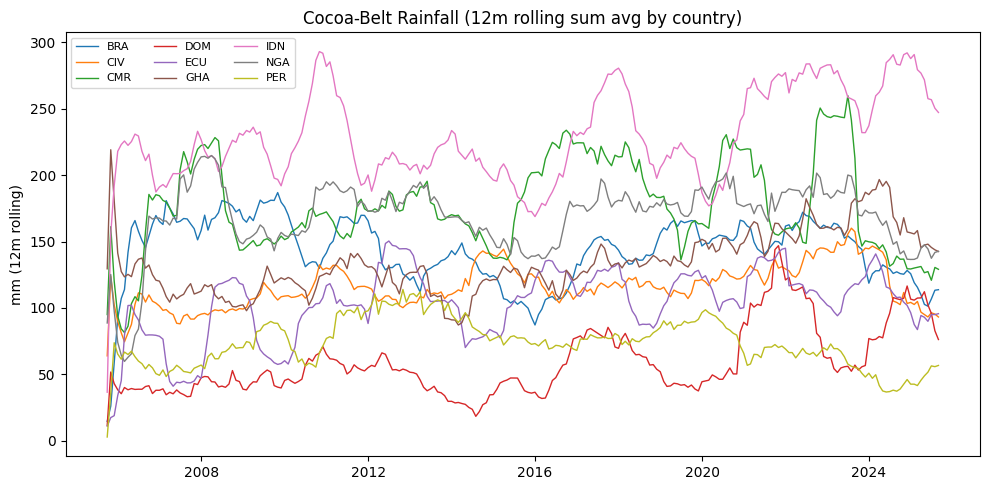

In [ ]:
import time, os, json, requests
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime

# 1) Time window (~20 years)
end_dt = pd.Timestamp.today().normalize() - pd.Timedelta(days=1)
start_dt = end_dt - pd.DateOffset(years=20)
start_str_ymd = start_dt.strftime("%Y%m%d")
end_str_ymd   = end_dt.strftime("%Y%m%d")

# 2) Cocoa prices (Yahoo)
sym = "CC=F"
px = yf.download(sym, start=start_dt.strftime("%Y-%m-%d"), end=end_dt.strftime("%Y-%m-%d"))
if px.empty:
    raise RuntimeError("Yahoo Finance returned no cocoa data.")
px = px.rename(columns={"Adj Close": "Close"}).reset_index()
px["Date"] = pd.to_datetime(px["Date"])
px_out = px[["Date","Open","High","Low","Close","Volume"]].rename(columns=str.lower)
px_out.to_csv("cocoa_cc_continuous_yahoo.csv", index=False)
print(f"Saved cocoa prices -> cocoa_cc_continuous_yahoo.csv  ({len(px_out)} rows, {px_out['date'].min().date()} .. {px_out['date'].max().date()})")

# 3) NASA POWER fetch helper
POWER_URL = "https://power.larc.nasa.gov/api/temporal/daily/point"
PARAMS = "T2M,PRECTOTCORR"   # °C, mm/day

def fetch_power_point(lat, lon, start_ymd, end_ymd, retries=3, pause=1.2):
    """Return daily DataFrame with index=date and columns ['T2M','PRECTOTCORR'] for a point."""
    params = {
        "parameters": PARAMS,
        "community": "AG",
        "latitude": f"{lat}",
        "longitude": f"{lon}",
        "start": start_ymd,
        "end": end_ymd,
        "format": "JSON"
    }
    last_err = None
    for _ in range(retries):
        try:
            r = requests.get(POWER_URL, params=params, timeout=60)
            r.raise_for_status()
            js = r.json()
            t2m = js["properties"]["parameter"]["T2M"]
            prc = js["properties"]["parameter"]["PRECTOTCORR"]
            df = pd.DataFrame({"T2M": pd.Series(t2m), "PRECTOTCORR": pd.Series(prc)})
            df.index = pd.to_datetime(df.index, format="%Y%m%d")
            df = df.sort_index(); df.index.name = "date"
            return df
        except Exception as e:
            last_err = e
            time.sleep(pause)
    raise last_err

# 4) Cocoa-belt sample points per producer
points = {
    # West Africa
    "CIV": [(5.8, -5.5), (6.5, -5.0), (6.2, -4.7), (5.2, -3.7)],            # Côte d’Ivoire
    "GHA": [(6.0, -1.0), (6.2, -0.5), (5.9, -2.3), (5.3, -1.6)],            # Ghana
    "NGA": [(6.6, 3.6), (6.9, 3.5), (5.8, 7.0), (5.2, 8.0)],                # Nigeria
    "CMR": [(5.6, 10.7), (4.7, 9.2), (3.9, 11.5)],                          # Cameroon
    # Latin America
    "ECU": [(-1.1, -79.5), (-0.6, -79.2), (0.7, -79.7), (0.9, -79.1)],      # Ecuador
    "BRA": [(-14.8, -39.3), (-15.2, -39.6), (-2.0, -47.5), (-1.5, -48.8)],  # Brazil
    "PER": [(-6.4, -76.7), (-7.1, -76.8), (-6.2, -77.0)],                   # Peru
    "DOM": [(19.2, -70.1), (18.9, -70.3), (19.5, -70.6)],                   # Dominican Republic
    # Asia
    "IDN": [(-3.7, 119.9), (-4.1, 122.0), (0.5, 101.5), (0.3, 103.0)],      # Indonesia
}


# 5) Fetch & aggregate to daily per country (equal-weight across points)

daily_country = []
for country, pts in points.items():
    series = []
    for lat, lon in pts:
        dfp = fetch_power_point(lat, lon, start_str_ymd, end_str_ymd)
        series.append(dfp)
        time.sleep(0.25)  # be nice to the API
    dfall = pd.concat(series, axis=1, keys=range(len(series)))  # MultiIndex columns: (i,'T2M'), (i,'PRECTOTCORR')
    t2m_cols = [c for c in dfall.columns if c[1] == "T2M"]
    prc_cols = [c for c in dfall.columns if c[1] == "PRECTOTCORR"]
    out = pd.DataFrame({
        "temp_c": dfall[t2m_cols].mean(axis=1, skipna=True),
        "rain_mm_day": dfall[prc_cols].mean(axis=1, skipna=True),
    })
    out["country"] = country
    out = out.reset_index()
    daily_country.append(out)

daily = pd.concat(daily_country, ignore_index=True).dropna().sort_values(["country","date"])

# 6) Aggregate to MONTHLY per country

def monthly_agg(g):
    g = g.set_index("date")
    mm_sum  = g["rain_mm_day"].resample("M").sum()   # total mm/month
    t2_mean = g["temp_c"].resample("M").mean()       # °C mean/month
    out = pd.DataFrame({"rain_mm": mm_sum, "temp_c": t2_mean})
    out["country"] = g["country"].iloc[0]
    return out.reset_index()

monthly = (daily.groupby("country", group_keys=False)
                .apply(monthly_agg)
                .sort_values(["country","date"]))

# Clip to time window (already constrained by fetch; keep for safety)
monthly = monthly[(monthly["date"] >= start_dt.normalize()) & (monthly["date"] <= end_dt.normalize())]

monthly.to_csv("weather_cocoa_global_monthly.csv", index=False)
print(f"Saved weather -> weather_cocoa_global_monthly.csv ({len(monthly)} rows)")
print(monthly.groupby("country").agg(first_date=("date","min"), last_date=("date","max"), rows=("date","count")))

# (Optional) quick visual sanity check (12m rolling rain by country)
try:
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(figsize=(10,5))
    for c in sorted(points.keys()):
        tmp = monthly[monthly["country"]==c].copy()
        ax.plot(tmp["date"], tmp["rain_mm"].rolling(12, min_periods=1).mean(), label=c, linewidth=1.0)
    ax.set_title("Cocoa-Belt Rainfall (12m rolling sum avg by country)")
    ax.set_ylabel("mm (12m rolling)")
    ax.legend(ncol=3, fontsize=8)
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("Plot preview skipped:", e)


This cell builds the Rainfall Growth Index (RGI), which penalizes droughts more heavily than excess rain, captures dry spells, and adjusts for supply shocks in each country. Country RGIs are aggregated into a production-weighted global index, converted into a supply-pressure factor, and lagged to respect causality.

/tmp/ipython-input-302791796.py:59: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  px_m = (px.set_index("date").resample("M").last()[["close"]]


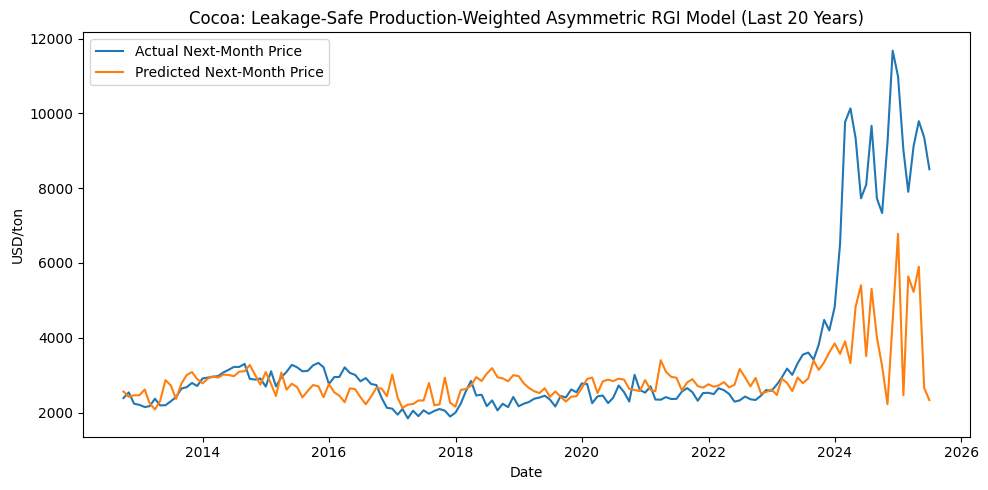

Saved: /content/cocoa_rgi_asym_weighted_predictions_last20y.csv
Pred vs Actual correlation (last 20y): 0.700
Countries present & nominal weights: {'BRA': 0.05, 'CIV': 0.43, 'CMR': 0.05, 'DOM': 0.02, 'ECU': 0.08, 'GHA': 0.19, 'IDN': 0.07, 'NGA': 0.06, 'PER': 0.02}


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from pathlib import Path

#Paths -----------------
prices_csv  = "cocoa_cc_continuous_yahoo.csv"
weather_csv = "weather_cocoa_global_monthly.csv"

#Production weights (approx shares)
W_PROD = {
    "CIV": 0.43, "GHA": 0.19, "IDN": 0.07, "ECU": 0.08,
    "NGA": 0.06, "CMR": 0.05, "BRA": 0.05, "DOM": 0.02, "PER": 0.02,
}

# Global shape/penalty defaults (drought heavier)
p, q = 2.0, 1.0           # exponents: drought p=2, excess q=1
alpha_i = 1.2             # below-target weight
delta_i = 0.4             # above-target weight
beta_i  = 0.6             # monthly deficits weight
eta_i   = 0.25            # longest dry spell weight
kappa_i = 0.15            # monthly surpluses weight
sigma_L_default = 250.0   # mm
sigma_H_default = 400.0   # mm unless noted

#Region-specific params
REG = {
    "CIV": {"T": 1800.0, "L": 100.0, "U": 300.0},
    "GHA": {"T": 1800.0, "L": 100.0, "U": 300.0},
    "IDN": {"T": 2000.0, "L": 110.0, "U": 350.0, "sigma_H": 450.0},
    "ECU": {"T": 1900.0, "L": 100.0, "U": 320.0},
    "NGA": {"T": 1800.0, "L": 100.0, "U": 300.0},
    "CMR": {"T": 2000.0, "L": 110.0, "U": 330.0},
    "BRA": {"T": 1700.0, "L":  90.0, "U": 300.0},
    "DOM": {"T": 1600.0, "L":  80.0, "U": 280.0},
    "PER": {"T": 1800.0, "L":  90.0, "U": 320.0},
}

#Load & monthly prices
px = pd.read_csv(prices_csv)
px["date"] = pd.to_datetime(px["date"], errors="coerce")
px["close"] = pd.to_numeric(px["close"], errors="coerce")
px = px.dropna(subset=["date","close"]).sort_values("date")
px_m = (px.set_index("date").resample("M").last()[["close"]]
          .rename(columns={"close":"px"})
          .dropna()
          .sort_index())

#Load weather
wx = pd.read_csv(weather_csv)
wx["date"] = pd.to_datetime(wx["date"], errors="coerce")
wx["rain_mm"] = pd.to_numeric(wx["rain_mm"], errors="coerce")
wx = wx.dropna(subset=["date","country","rain_mm"]).sort_values(["country","date"])

#Helpers
M = 12

def longest_below(series, thresh):
    """Longest consecutive run of months < thresh within the LAST 12 months (approx)."""
    below = (series < thresh).astype(int)
    run = np.zeros(len(below), dtype=int)
    for i, b in enumerate(below):
        run[i] = run[i-1] + 1 if (b == 1 and i > 0) else (1 if b == 1 else 0)
    return pd.Series(run, index=series.index).rolling(M, min_periods=M).max()

def rgi_asym_leakage_safe(rain_mm, T, L, U, sigma_L=sigma_L_default, sigma_H=sigma_H_default):
    """
    Compute RGI at month t using ONLY information up to month t-1:
      - All rolling windows are built on rain.shift(1).
    """
    rain = rain_mm.sort_index().copy()
    rain_lag1 = rain.shift(1)
    R12 = rain_lag1.rolling(M, min_periods=M).sum()

    drought_term = np.maximum(0.0, T - R12) / sigma_L
    excess_term  = np.maximum(0.0, R12 - T) / sigma_H
    A = np.exp(-(alpha_i * (drought_term ** p) + delta_i * (excess_term ** q)))

    deficit = np.maximum(0.0, L - rain_lag1) / L
    surplus = np.maximum(0.0, rain_lag1 - U) / U
    sum_def = (deficit ** p).rolling(M, min_periods=M).sum()
    sum_sur = (surplus ** q).rolling(M, min_periods=M).sum()

    Lmax = longest_below(rain_lag1, L)

    D = np.exp(-(beta_i * sum_def)) * np.exp(-(eta_i * Lmax))
    W = np.exp(-(kappa_i * sum_sur))

    RGI = A * D * W
    return RGI

#Per-country RGI
rgi_list = []
for cty, g in wx.groupby("country", sort=False):
    if cty not in REG:
        continue
    params = REG[cty]
    rgi_series = rgi_asym_leakage_safe(
        rain_mm=g.set_index("date")["rain_mm"],
        T=params["T"], L=params["L"], U=params["U"],
        sigma_L=sigma_L_default, sigma_H=params.get("sigma_H", sigma_H_default)
    )
    out = pd.DataFrame({"date": rgi_series.index, "country": cty, "RGI": rgi_series.values})
    rgi_list.append(out)

rgi = (pd.concat(rgi_list, ignore_index=True)
         .dropna(subset=["RGI"])
         .sort_values(["country","date"]))

#Production-weighted global index (renormalize for missing)
rgi_wide = rgi.pivot(index="date", columns="country", values="RGI").sort_index()

def weighted_global_rgi(row, weights):
    present = row.dropna()
    if present.empty:
        return np.nan
    w = np.array([weights.get(cty, 0.0) for cty in present.index], dtype=float)
    if w.sum() == 0:
        w = np.ones_like(w)
    w = w / w.sum()
    return float(np.dot(present.values, w))

RGI_global = rgi_wide.apply(lambda r: weighted_global_rgi(r, W_PROD), axis=1).rename("RGI_global")

# Supply pressure: higher RGI ⇒ more supply ⇒ downward price pressure
feat = pd.DataFrame({"supply_pressure": -RGI_global}).sort_index()

# Add lags — L=0 is safe because RGI(t) already uses data only up to t-1
LAGS = [0,1,2,3,4,5,6,9,12]
for L in LAGS:
    feat[f"supply_pressure_lag{L}"] = feat["supply_pressure"].shift(L)

feature_cols = [c for c in feat.columns if c.startswith("supply_pressure_lag")]

#Merge with price & TARGET
df = (px_m.join(feat, how="inner")).copy()
df["px_next"] = df["px"].shift(-1)
# Keep rows where features at time t and target at t+1 both exist
df = df.dropna(subset=feature_cols + ["px","px_next"])

#Walk-forward training (expanding window
pred = pd.Series(index=df.index, dtype=float)
min_train_months = 60  # ~5 years before first prediction

model = GradientBoostingRegressor(random_state=123, n_estimators=600, max_depth=3, learning_rate=0.03)

for i in range(min_train_months, len(df) - 1):
    X_train = df.iloc[:i][feature_cols]
    y_train = df.iloc[:i]["px_next"]
    X_pred  = df.iloc[[i]][feature_cols]
    model.fit(X_train, y_train)
    pred.iloc[i] = float(model.predict(X_pred)[0])

pred.name = "px_pred_next_rgi_asym_weighted_safe"

px_actual_next = df["px"].shift(-1)
eval_df = pd.concat(
    [px_actual_next.rename("px_actual_next"), pred], axis=1
).dropna()

cut = eval_df.index.max() - pd.DateOffset(years=20)
eval_df = eval_df.loc[eval_df.index >= cut].copy()

plt.figure(figsize=(10,5))
plt.plot(eval_df.index, eval_df["px_actual_next"], label="Actual Next-Month Price")
plt.plot(eval_df.index, eval_df["px_pred_next_rgi_asym_weighted_safe"], label="Predicted Next-Month Price")
plt.title("Cocoa: Leakage-Safe Production-Weighted Asymmetric RGI Model (Last 20 Years)")
plt.xlabel("Date"); plt.ylabel("USD/ton"); plt.legend(); plt.tight_layout(); plt.show()

out_path = (Path("/mnt/data") if Path("/mnt/data").exists() else Path(".")) / "cocoa_rgi_asym_weighted_predictions_last20y.csv"
eval_df.to_csv(out_path, index=True)
print(f"Saved: {out_path.resolve()}")

corr_pa = eval_df["px_pred_next_rgi_asym_weighted_safe"].corr(eval_df["px_actual_next"])
print(f"Pred vs Actual correlation (last 20y): {corr_pa:.3f}")

present = [c for c in rgi_wide.columns if rgi_wide[c].notna().any()]
print("Countries present & nominal weights:", {c: W_PROD.get(c, 0.0) for c in present})



A Gradient Boosting Regressor is trained in a walk-forward expanding window to predict next-month cocoa prices. The predictions feed into a long/short backtest with thresholds, confidence-based position sizing, volatility targeting, and transaction costs. The outputs include model correlation with realized prices, Sharpe ratio, CAGR, drawdowns, and equity curves compared to buy-and-hold.

=== Long/Short Backtest (threshold + confidence + vol targeting) ===
Periods: 153
CAGR (strategy): 0.46%
CAGR (buy&hold): 10.48%
Sharpe: 0.10 | Hit rate: 48.4% | MaxDD: -49.5%
Threshold=3.0%, ConfPow=1.25, PosCap=1.0, Cost=2.0 bps, RollVol=6m, TargetVol=15%, SL=None, TP=None


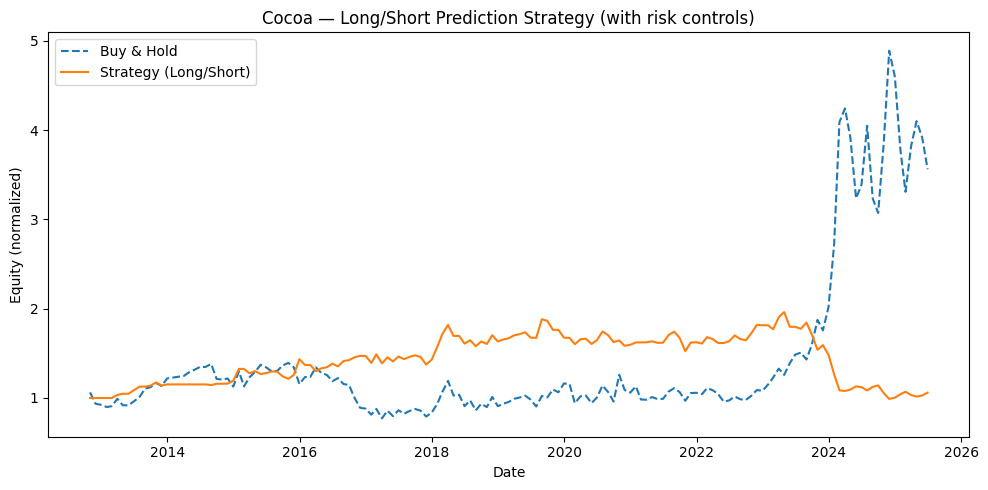

Monthly return correlation (strat vs underlying): -0.13
Avg monthly turnover (abs Δposition): 0.229


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

if "eval_df" not in globals():
    raise RuntimeError("Run your predictor cell first to create `eval_df`.")

df = eval_df.copy()
pred_col = [c for c in df.columns if c != "px_actual_next"][0]
df = df.rename(columns={"px_actual_next":"actual", pred_col:"pred"}).dropna().copy()

THRESHOLD   = 0.03      # trade only if |pred/current - 1| >= 3%
CONF_POW    = 1.25      # position grows with signal^CONF_POW (>=1)
POS_CAP     = 1.0       # hard cap on |position|
COST_BPS    = 2.0       # round-trip cost in bps applied on position changes
ROLL_VOL_M  = 6         # lookback (months) for realized vol
TARGET_VOL  = 0.15      # target annualized vol for the strategy (15%)
SL_PCT      = None      # per-month stop-loss; e.g. 0.08 for 8% (None disables)
TP_PCT      = None      # per-month take-profit; e.g. 0.10 (None disables)

df["current"] = df["actual"].shift(1)
df["ret"]     = df["actual"].pct_change()

df["edge"] = (df["pred"] / df["current"]) - 1.0

conf_raw = (np.abs(df["edge"]) - THRESHOLD).clip(lower=0) / max(THRESHOLD, 1e-9)
size_conf = (conf_raw ** CONF_POW).clip(upper=POS_CAP)

pos_dir = np.sign(df["edge"]).fillna(0.0)
df["pos_raw"] = (pos_dir * size_conf).fillna(0.0)

ret = df["ret"].fillna(0.0)
real_vol_ann = (ret.rolling(ROLL_VOL_M).std() * np.sqrt(12)).replace(0, np.nan)
scaler = (TARGET_VOL / real_vol_ann).clip(upper=1.0)
df["pos_voltgt"] = (df["pos_raw"] * scaler).fillna(0.0).clip(-POS_CAP, POS_CAP)

# Position applied for the next month is the lagged (decided last month)
df["pos"] = df["pos_voltgt"].shift(1).fillna(0.0)

# Strategy return before costs
strat_ret = df["pos"] * df["ret"]

# Optional SL/TP on monthly bar (coarse)
if SL_PCT is not None:
    strat_ret = strat_ret.where(strat_ret >= -abs(SL_PCT), -abs(SL_PCT))
if TP_PCT is not None:
    strat_ret = strat_ret.where(strat_ret <=  abs(TP_PCT),  abs(TP_PCT))

# Apply trading costs on position changes
pos_change = df["pos"].diff().fillna(df["pos"])
cost = np.abs(pos_change) * (COST_BPS / 1e4)
df["strat_ret"] = strat_ret - cost

# Drop NaNs created at the start
df_bt = df.dropna(subset=["strat_ret", "ret"]).copy()

# Equity curves
df_bt["cum_strategy"] = (1 + df_bt["strat_ret"]).cumprod()
df_bt["cum_buyhold"]  = (1 + df_bt["ret"]).cumprod()

# Performance stats
ANN = 12.0
def cagr(curve):
    n = len(curve)
    return curve.iloc[-1]**(ANN/n) - 1 if n > 1 else np.nan
sharpe = (np.sqrt(ANN) * df_bt["strat_ret"].mean() / df_bt["strat_ret"].std()) if df_bt["strat_ret"].std() > 0 else np.nan
hit    = (df_bt["strat_ret"] > 0).mean()
mdd    = (df_bt["cum_strategy"] / df_bt["cum_strategy"].cummax() - 1).min()

print("=== Long/Short Backtest (threshold + confidence + vol targeting) ===")
print(f"Periods: {len(df_bt)}")
print(f"CAGR (strategy): {cagr(df_bt['cum_strategy']):.2%}")
print(f"CAGR (buy&hold): {cagr(df_bt['cum_buyhold']):.2%}")
print(f"Sharpe: {sharpe:.2f} | Hit rate: {hit:.1%} | MaxDD: {mdd:.1%}")
print(f"Threshold={THRESHOLD:.1%}, ConfPow={CONF_POW}, PosCap={POS_CAP}, Cost={COST_BPS} bps,"
      f" RollVol={ROLL_VOL_M}m, TargetVol={TARGET_VOL:.0%}, SL={SL_PCT}, TP={TP_PCT}")

# Plot
plt.figure(figsize=(10,5))
plt.plot(df_bt.index, df_bt["cum_buyhold"],  label="Buy & Hold", linestyle="--")
plt.plot(df_bt.index, df_bt["cum_strategy"], label="Strategy (Long/Short)")
plt.title("Cocoa — Long/Short Prediction Strategy (with risk controls)")
plt.xlabel("Date"); plt.ylabel("Equity (normalized)")
plt.legend(); plt.tight_layout(); plt.show()

# Quick diagnostics
corr = df_bt["strat_ret"].corr(df_bt["ret"])
turnover = np.abs(pos_change).sum() / len(df_bt)
print(f"Monthly return correlation (strat vs underlying): {corr:.2f}")
print(f"Avg monthly turnover (abs Δposition): {turnover:.3f}")


